In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# inspired by exercises 8
from abc import abstractmethod, ABC
import os

import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output
#from backbones.fcnet import FCNet
from fcnet import FCNet

import matplotlib.pyplot as plt

import pickle


In [3]:
from datasets.prot.utils import get_samples_using_ic, check_min_samples, get_mode_ids, encodings, get_ids

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)


In [4]:
class MetaTemplate(nn.Module):
    def __init__(self, backbone, n_way, n_support):
        super(MetaTemplate, self).__init__()
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = -1  # (change depends on input)
        self.feature = backbone
        self.feat_dim = self.feature.final_feat_dim

        # n_way = nb_classes per episode
        # n_support = nb_samples per class for support set
        # n_query = nb_samples per class for query set
        # backbone = feature extractor (embedding network) ie. function f

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    @abstractmethod
    def set_forward(self, x, is_feature=False):
        """
        forward pass, returns score (probabilities for query set)
        output is logits for all query set (prob of each class)
        first dim of output is n_way * n_query, nb of samples in query set
        second dim is prob to belong to each class
        x: [n_way, n_support + n_query, **embedding_dim]
        out: [n_way * n_query, n_way]
        """
        pass

    @abstractmethod
    def set_forward_loss(self, x):
        """
        takes the episode and compute loss of episode
        x: [n_way, n_support + n_query, **embedding_dim]
        out: loss (scalar)
        """
        
        pass

    def forward(self, x):
        out = self.feature.forward(x)
        return out

    def parse_feature(self, x):
        '''
        create embeddings for support and query set
        :param x: [n_way, n_support + n_query, **embedding_dim]
        out: z_supp, z_query¨
            z_supp: [n_way, n_support, feat_dim]
            z_query: [n_way, n_query, feat_dim]
        '''
        x = Variable(x.to(self.device))
        # reshape x to create one batch of size n_way * (n_support + n_query) and of dim whatever is dim of x
        # x is of shape [n_way, n_support + n_query, **embedding_dim] originally, we have to reshape it to pass it to the NN ie. shape (batch_size, dim_size)
        # note: x.contigous is used to make sure that is in the same place in mem (more efficient)
        x = x.contiguous().view(self.n_way * (self.n_support + self.n_query), * x.size()[2:])
        # Compute support and query feature.
        z_all = self.forward(x)

        # Reverse the transformation to distribute the samples based on the dimensions of their individual categories and flatten the embeddings.
        # transformation is the transformation just above to one batch, ie. transform to original shape [n_way, n_support + n_query, **embedding_dim]
        z_all = z_all.view(self.n_way, self.n_support + self.n_query, -1)

        # Extract the support and query features.
        z_support = z_all[:, :self.n_support, :]
        z_query = z_all[:, self.n_support:, :]

        return z_support, z_query

    def correct(self, x):
        # Compute the predictions scores.
        scores = self.set_forward(x)

        # Compute the top1 elements.
        topk_scores, topk_labels = scores.data.topk(k=1, dim=1, largest=True, sorted=True)

        # Detach the variables (transforming to numpy also detach the tensor)
        topk_ind = topk_labels.cpu().numpy()

        # Create the category labels for the queries, this is unique for the few shot learning setup
        y_query = np.repeat(range(self.n_way), self.n_query)

        #>>> np.repeat(range(10), 2)
        #array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])

        # Compute number of elements that are correctly classified.
        top1_correct = np.sum(topk_ind[:, 0] == y_query)
        return float(top1_correct), len(y_query)

    def train_loop(self, epoch, train_loader, optimizer):
        print_freq = 10

        avg_loss = 0
        for i, (x, _) in enumerate(train_loader):
            self.n_query = x.size(1) - self.n_support
            optimizer.zero_grad()
            loss = self.set_forward_loss(x)
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss + loss.item()

            if i % print_freq == 0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader),
                                                                        avg_loss / float(i + 1)))
        return avg_loss/len(train_loader)
    
    def test_loop(self, epoch, test_loader, record=None, return_std=False):
        acc_all = []

        iter_num = len(test_loader)
        for i, (x, _) in enumerate(test_loader):
            self.n_query = x.size(1) - self.n_support
            correct_this, count_this = self.correct(x)
            acc_all.append(correct_this / count_this * 100)

        acc_all = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)
        acc_std = np.std(acc_all)
        print(f'Epoch {epoch} | Test Acc = {acc_mean:4.2f}% +- {1.96 * acc_std / np.sqrt(iter_num):4.2f}%')

        if return_std:
            return acc_mean, acc_std
        else:
            return acc_mean

# Can network 2 loss

In [5]:
# This code is modified from https://github.com/blue-blue272/fewshot-CAN

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from methods.meta_template import MetaTemplate


class CanNet(MetaTemplate):
    def __init__(self, backbone, n_way, n_support, reduction_ratio=6, temperature=0.025, scale_cls=7):
        super(CanNet, self).__init__(backbone, n_way, n_support)
        self.m = self.feat_dim
        self.loss_fn = nn.CrossEntropyLoss()
        self.linear = nn.Linear(self.m, n_way)
        self.fusion_conv = nn.Conv1d(self.feat_dim, 1, kernel_size=1)
        self.bn = nn.BatchNorm1d(int(self.feat_dim / reduction_ratio))
        self.w1 = nn.Linear(self.m, int(self.m / reduction_ratio))
        self.activation = nn.ReLU()
        self.w2 = nn.Linear(int(self.m / reduction_ratio), self.m)
        self.softmax = nn.Softmax(dim=-1)
        self.temperature = temperature
        self.scale_cls = scale_cls

    def set_forward(self, x, is_feature=False):
        z_support, z_query = self.parse_feature(x, is_feature)

        z_support = z_support.contiguous()
        z_proto = z_support.view(self.n_way, self.n_support, -1).mean(1)  # the shape of z is [n_data, n_dim]
        
        #z_query = z_query.contiguous().view(self.n_way * self.n_query, -1)


        z_proto_attention = torch.zeros_like(z_query).cuda() # shape: [n_way, n_dim]
        z_query_attention = torch.zeros_like(z_query).cuda() # shape: [n_way * n_query, n_dim]
        for i in range(z_proto.shape[0]):
            for j in range(z_query.shape[1]):
                attention_map_i = self.cross_attention_module(z_proto[i], z_query[i, j])
                z_proto_attention[i, j], z_query_attention[i, j] = attention_map_i
            
        ftrain = z_proto_attention
        ftest = z_query_attention

        # Normalize ftest and ftrain along the feature dimension
        ftest_norm = F.normalize(ftest, p=2, dim=1, eps=1e-12)
        ftrain_norm = F.normalize(ftrain, p=2, dim=1, eps=1e-12)

        #print("ftest_norm: ", ftest_norm.shape)
        #print("ftrain: ", ftrain_norm.shape)
        #ftest_norm:  torch.Size([5, 15, 64])
        #ftrain:  torch.Size([5, 15, 64])           


        # Calculate cls_scores by taking the matrix product of ftest_norm and ftrain_norm (transposed)
        cls_scores = self.scale_cls * torch.sum(ftest_norm.unsqueeze(1) * ftrain_norm.unsqueeze(0), dim=-1)
        cls_scores = cls_scores.view(self.n_way * self.n_query, self.n_way)

        ftest = ftest.view(self.n_way * self.n_query, -1)

        # why this matmul ?
        #ftest = torch.matmul(y_query, ftest)
        ytest = self.linear(ftest)

        return cls_scores, ytest
    
    def set_forward_loss(self, x):
        y_query = torch.from_numpy(np.repeat(range( self.n_way ), self.n_query ))
        y_query = Variable(y_query.cuda())

        #scores, cls_scores = self.set_forward(x)
        cls_scores, ytest = self.set_forward(x)

        l1 = self.loss_fn(ytest, y_query)
        l2 = self.loss_fn(cls_scores, y_query )
        loss = (l1 + l2) / 2
        
        #loss = l1
        

        return loss

    def fusion_layer(self, z):
        """
        Generates cross attention map A
        :param R: [n_dim,n_dim]
        :return: A  [n_dim]
        """

        GAP = torch.mean(z, dim=-1)

        conv1 = self.w1(GAP)
        #conv1 = self.bn(conv1.unsqueeze(-1))
        w = self.w2(self.activation(conv1))

        conv = torch.mean(z * w,dim=-1)

        A = self.softmax(conv/self.temperature)

        return A

    def cross_attention_module(self, z_support, z_query):
        """
        TODO: do this operation for all pairs at once instead of looping, look at base code
        Takes 1 support embedding and 1 query embedding and returns cross-attentioned embeddings
        :param z_support: [n_dim]
        :param z_query: [n_dim]
        """


        def correlation_layer(z_support, z_query): 
            """
            Takes 1 support embedding and 1 query embedding and returns correlation map
            ie. P and Q in the paper. P is [P1, P2, ..., Pn] where n is the dimension of the embeddings, same for Q.
            :param z_support: [n_dim] ie. P
            :param z_query: [n_dim] ie. Q
            :return: correlation_map: [n_dim, n_dim]. Note: we use R^q = correlation_map and R^p = correlation_map.T 
            """

            # compute cosine similarity between support and query embeddings
            #print("z_support_shape", z_support.shape)
            #print("z_query_shape", z_query.shape)

            #P = z_support / torch.linalg.norm(z_support, ord=2)
            #Q = z_query / torch.linalg.norm(z_query, ord=2)
            P = F.normalize(z_support, p=2, dim=0, eps=1e-12)
            Q = F.normalize(z_query, p=2, dim=0, eps=1e-12)

            #print("P shape after norm", P.shape)
            #print("Q shape after norm", Q.shape)
            # P is of dim (n_dim) and Q is of dim (ndim)
            # we need to change P to (n_dim, 1) and Q to (ndim, 1)
            #P = P.reshape(P.shape, 1)
            #Q = Q.reshape(Q.shape, 1)
            #print("P shape after reshape", P.shape)
            #print("Q shape after reshape", Q.shape)
            correlation_map = P.unsqueeze(1) @ Q.unsqueeze(1).T # dim: [n_dim, n_dim]
            #print("correlation shape", correlation_map.shape)

            return correlation_map

        P_k = z_support
        Q_b = z_query

        # compute correlation map
        R_p = correlation_layer(P_k, Q_b)
        R_q = R_p.T

        # compute fusion layer
        A_p = self.fusion_layer(R_p)
        A_q = self.fusion_layer(R_q)

        P_bk = P_k * (1 + A_p)
        Q_bk = Q_b * (1 + A_q)

        return P_bk, Q_bk
    
    def correct(self, x):
        #scores, _ = self.set_forward(x)
        scores, _ = self.set_forward(x)
        y_query = np.repeat(range(self.n_way), self.n_query)

        topk_scores, topk_labels = scores.data.topk(1, 1, True, True)
        topk_ind = topk_labels.cpu().numpy()
        top1_correct = np.sum(topk_ind[:, 0] == y_query)
        return float(top1_correct), len(y_query)

    def train_loop(self, epoch, train_loader, optimizer):
        print_freq = 10

        avg_loss = 0
        for i, (x, _) in enumerate(train_loader):
            self.n_query = x.size(1) - self.n_support
            optimizer.zero_grad()
            loss = self.set_forward_loss(x)
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss + loss.item()

            if i % print_freq == 0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader),
                                                                        avg_loss / float(i + 1)))
        return avg_loss/len(train_loader)
 


# Can network 1 loss

In [6]:
# This code is modified from https://github.com/blue-blue272/fewshot-CAN

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from methods.meta_template import MetaTemplate


class CanNet(MetaTemplate):
    def __init__(self, backbone, n_way, n_support, reduction_ratio=6, temperature=0.025, scale_cls=7):
        super(CanNet, self).__init__(backbone, n_way, n_support)
        self.m = self.feat_dim
        self.loss_fn = nn.CrossEntropyLoss()
        self.linear = nn.Linear(self.m, n_way)
        self.fusion_conv = nn.Conv1d(self.feat_dim, 1, kernel_size=1)
        self.bn = nn.BatchNorm1d(int(self.feat_dim / reduction_ratio))
        self.w1 = nn.Linear(self.m, int(self.m / reduction_ratio))
        self.activation = nn.ReLU()
        self.w2 = nn.Linear(int(self.m / reduction_ratio), self.m)
        self.softmax = nn.Softmax(dim=-1)
        self.temperature = temperature
        self.scale_cls = scale_cls

    def set_forward(self, x, is_feature=False):
        z_support, z_query = self.parse_feature(x, is_feature)

        z_support = z_support.contiguous()
        z_proto = z_support.view(self.n_way, self.n_support, self.m).mean(1)  # the shape of z is [n_data, n_dim]
        z_query = z_query.contiguous().view(self.n_way * self.n_query, self.m)
        z_proto_attention = torch.zeros((self.n_support,self.n_way * self.n_query, self.m)).cuda() # shape: [n_way , n-query, n_dim]
        z_query_attention = torch.zeros((self.n_support,self.n_way * self.n_query, self.m)).cuda() # shape: [n_way , n_query, n_dim]
        z_proto_attention, z_query_attention = self.cross_attention_module(z_proto, z_query)
        ftrain = z_proto_attention # torch.Size([5, 75, 64])
        ftest = z_query_attention #torch.Size([5, 75, 64])

        ftrain = ftrain.mean(2) # torch.Size([5, 75])

        # Normalize ftest and ftrain along the feature dimension
        ftest_norm = F.normalize(ftest, p=2, dim=1, eps=1e-12) # torch.Size([5, 75, 64]
        ftrain_norm = F.normalize(ftrain, p=2, dim=1, eps=1e-12) # torch.Size([5, 75])    

        ftrain_norm = ftrain_norm.unsqueeze(2) # torch.Size([5, 75, 1])
        # Calculate cls_scores by taking the matrix product of ftest_norm and ftrain_norm (transposed)
        cls_scores = self.scale_cls * torch.sum(ftest_norm * ftrain_norm, dim=2) # torch.Size([5, 64])
        cls_scores = cls_scores.view(self.n_way * self.n_query, self.n_way)

        return cls_scores
    
    def set_forward_loss(self, x):
        y_query = torch.from_numpy(np.repeat(range( self.n_way ), self.n_query ))
        y_query = Variable(y_query.cuda())

        #scores, cls_scores = self.set_forward(x)
        cls_scores = self.set_forward(x)

        #l1 = self.loss_fn(ytest, y_query)
        l2 = self.loss_fn(cls_scores, y_query )
        #loss = (l1 + l2) / 2
        
        loss = l2
        

        return loss

    def fusion_layer(self, z):
        """
        Generates cross attention map A
        :param R: [n_dim,n_dim]
        :return: A  [n_dim]
        """

        GAP = torch.mean(z, dim=-2)

        w = self.w2(self.activation(self.w1(GAP)))


        fusion = z * w.unsqueeze(2) /self.temperature

        conv = torch.mean(fusion,dim=-1)

        A = self.softmax(conv/self.temperature)

        return A

    def cross_attention_module(self, z_support, z_query):
        """
        TODO: do this operation for all pairs at once instead of looping, look at base code
        Takes 1 support embedding and 1 query embedding and returns cross-attentioned embeddings
        :param z_support: [n_dim]
        :param z_query: [n_dim]
        """


        def correlation_layer(z_support, z_query): 
            """
            Takes 1 support embedding and 1 query embedding and returns correlation map
            ie. P and Q in the paper. P is [P1, P2, ..., Pn] where n is the dimension of the embeddings, same for Q.
            :param z_support: [n_dim] ie. P
            :param z_query: [n_dim] ie. Q
            :return: correlation_map: [n_dim, n_dim]. Note: we use R^q = correlation_map and R^p = correlation_map.T 
            """

            # compute cosine similarity between support and query embeddings
            #print("z_support_shape", z_support.shape)
            #print("z_query_shape", z_query.shape)

            #P = z_support / torch.linalg.norm(z_support, ord=2)
            #Q = z_query / torch.linalg.norm(z_query, ord=2)
            P = F.normalize(z_support, p=2, dim=-1, eps=1e-12)
            Q = F.normalize(z_query, p=2, dim=-1, eps=1e-12)

            #print("P shape after norm", P.shape)
            #print("Q shape after norm", Q.shape)
            # P is of dim (n_dim) and Q is of dim (ndim)
            # we need to change P to (n_dim, 1) and Q to (ndim, 1)
            #P = P.reshape(P.shape, 1)
            #Q = Q.reshape(Q.shape, 1)
            #print("P shape after reshape", P.shape)
            #print("Q shape after reshape", Q.shape)
            correlation_map = torch.einsum("ij,kl->ikjl",P,Q)  # dim: [n_dim, n_dim]
            #print("correlation shape", correlation_map.shape)

            return correlation_map

        P_k = z_support
        Q_b = z_query

        # compute correlation map
        R_p = correlation_layer(P_k, Q_b)
        R_q = R_p.transpose(2, 3)

        # compute fusion layer
        A_p = self.fusion_layer(R_p)
        A_q = self.fusion_layer(R_q)

        """
        A_p = A_p * P_k
        P_bk = A_p + P_k

        A_q = A_q * Q_b
        Q_bk = A_q + Q_b
        """
        P_bk = P_k.unsqueeze(1) * (1 + A_p)
        Q_bk = Q_b.unsqueeze(0) * (1 + A_q)

        return P_bk, Q_bk
    
    def correct(self, x):
        #scores, _ = self.set_forward(x)
        scores = self.set_forward(x)
        y_query = np.repeat(range(self.n_way), self.n_query)

        topk_scores, topk_labels = scores.data.topk(1, 1, True, True)
        topk_ind = topk_labels.cpu().numpy()
        top1_correct = np.sum(topk_ind[:, 0] == y_query)
        return float(top1_correct), len(y_query)

    def train_loop(self, epoch, train_loader, optimizer):
        print_freq = 10

        avg_loss = 0
        for i, (x, _) in enumerate(train_loader):
            self.n_query = x.size(1) - self.n_support
            optimizer.zero_grad()
            loss = self.set_forward_loss(x)
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss + loss.item()

            if i % print_freq == 0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader),
                                                                        avg_loss / float(i + 1)))
        return avg_loss/len(train_loader)
 


In [7]:
class FewShotDataset(Dataset):
    """
    Special class for few-shot dataset
    """

    def __init__(self):
        self.check_init()

    def check_init(self):
        """
        Convenience function to check that the FewShotDataset is properly configured.
        """
        required_attrs = ['_dataset_name', '_data_dir']
        for attr in required_attrs:
            if not hasattr(self, attr):
                raise ValueError(f'FewShotDataset must have attribute {attr}.')

        if not os.path.exists(self._data_dir):
            raise ValueError(
                f'{self._data_dir} does not exist yet. Please generate/download the dataset first.')


    @abstractmethod
    def __getitem__(self, i):
        return NotImplemented

    @abstractmethod
    def __len__(self):
        return NotImplemented

    @property
    @abstractmethod
    def dim(self):
        return NotImplemented

    @abstractmethod
    def get_data_loader(self, mode='train') -> DataLoader:
        return NotImplemented

    @property
    def dataset_name(self):
        """
        A string that identifies the dataset, e.g., 'swissprot'
        """
        return self._dataset_name

    @property
    def data_dir(self):
        return self._data_dir

    def initialize_data_dir(self, root_dir):
        os.makedirs(root_dir, exist_ok=True)
        #self._data_dir = os.path.join(root_dir, self._dataset_name)
        self._data_dir = "data/swissprot"

class SPDataset(FewShotDataset, ABC):
    _dataset_name = 'swissprot'

    def load_swissprot(self, level = 5, mode='train', min_samples = 20):
        samples = get_samples_using_ic(root = self.data_dir)
        samples = check_min_samples(samples, min_samples)
        unique_ids = set(get_mode_ids(samples)[mode])
        return [sample for sample in samples if sample.annot in unique_ids]

In [8]:
PROTDIM = 1280

class SubDataset(Dataset):
    def __init__(self, samples, data_dir):
        self.samples = samples
        self.encoder = encodings(data_dir)

    def __getitem__(self, i):
        sample = self.samples[i]
        return sample.input_seq, self.encoder[sample.annot]

    def __len__(self):
        return len(self.samples)

    @property
    def dim(self):
        return PROTDIM

class EpisodicBatchSampler(object):
    def __init__(self, n_classes, n_way, n_episodes):
        self.n_classes = n_classes
        self.n_way = n_way
        self.n_episodes = n_episodes

    def __len__(self):
        return self.n_episodes

    def __iter__(self):
        for i in range(self.n_episodes):
            yield torch.randperm(self.n_classes)[:self.n_way]

class SPSetDataset(SPDataset):
    def __init__(self, n_way, n_support, n_query, n_episode=100, root='./data', mode='train'):
        self.initialize_data_dir(root)

        self.n_way = n_way
        self.n_episode = n_episode
        min_samples = n_support + n_query
        self.encoder = encodings(self.data_dir)

        # check if samples_all.pkl exists
        if os.path.exists('samples_all.pkl'):
            # load samples_all using pickle
            with open('samples_all.pkl', 'rb') as f:
                samples_all = pickle.load(f)
        else:
            samples_all = self.load_swissprot(mode = mode, min_samples = min_samples)

            # save samples_all using pickle
            with open('samples_all.pkl', 'wb') as f:
                pickle.dump(samples_all, f)
            


        self.categories = get_ids(samples_all) # Unique annotations
        self.x_dim = PROTDIM

        self.sub_dataloader = []

        sub_data_loader_params = dict(batch_size=min_samples,
                                      shuffle=True,
                                      num_workers=0,  # use main thread only or may receive multiple batches
                                      pin_memory=False)

        # Create the sub datasets for each annotation of the categories and collect all the dataloaders in `self.sub_dataloader`.
        for annotation in self.categories:
            samples = [sample for sample in samples_all if sample.annot == annotation]
            sub_dataset = SubDataset(samples, self.data_dir)
            self.sub_dataloader.append(torch.utils.data.DataLoader(sub_dataset, **sub_data_loader_params))

        super().__init__()

    def __getitem__(self, i):
        return next(iter(self.sub_dataloader[i]))

    def __len__(self):
        return len(self.categories)

    @property
    def dim(self):
        return self.x_dim

    def get_data_loader(self) -> DataLoader:
        sampler = EpisodicBatchSampler(len(self), self.n_way, self.n_episode)
        data_loader_params = dict(batch_sampler=sampler, num_workers=0, pin_memory=True)
        
        # check if data_loader.pkl exists
        if os.path.exists('data_loader.pkl'):
            # load data_loader using pickle
            with open('data_loader.pkl', 'rb') as f:
                data_loader = pickle.load(f)
        else:
            data_loader = torch.utils.data.DataLoader(self, **data_loader_params)
        
            # save data_loader using pickle
            with open('data_loader.pkl', 'wb') as f:
                pickle.dump(data_loader, f)
        return data_loader

In [9]:
def train_model(n_way, n_support, n_query, n_train_episode):
    # Load train dataset. Remember to use make use of functions defined in the `SPSetDataset`.
    
    if os.path.exists('train_dataset.pkl'):
        # load train_dataset using pickle
        with open('train_dataset.pkl', 'rb') as f:
            train_dataset = pickle.load(f)
    else:
        train_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=n_train_episode, root='./data', mode='train')
        # save as pickle
        with open('train_dataset.pkl', 'wb') as f:
            pickle.dump(train_dataset, f)
    train_loader = train_dataset.get_data_loader()

    # Load test dataset. Remember to use make use of functions defined in the `SPSetDataset`.
    if os.path.exists('test_dataset.pkl'):
        # load test_dataset using pickle
        with open('test_dataset.pkl', 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=100, root='./data', mode='test')
        # save as pickle
        with open('test_dataset.pkl', 'wb') as f:
            pickle.dump(test_dataset, f)
    test_loader =  test_dataset.get_data_loader()

    # Initialize a fully connected network `FCNet` in `fcnet.py` with two hidden layers of 512 units each as feature extractor.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone = FCNet(train_dataset.dim).to(device)


    # Initialize model using the backbone and the optimizer.
    model = CanNet(backbone, n_way, n_support).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    test_accs = []; train_losses = []
    for epoch in range(100):
        model.train()

        # Implement training of the model. Remember to make use of functions defined in the `ProtoNet` and `MetaTemplate` class.
        epoch_loss = model.train_loop(epoch, train_loader, optimizer)
        train_losses.append(epoch_loss)

        # Evaluate test performance for epoch. Remember to make use of functions defined in the `ProtoNet` and `MetaTemplate` class.
        test_acc = model.test_loop(test_loader)
        test_accs.append(test_acc)
        print(f'Epoch {epoch} | Train Loss {epoch_loss} | Test Acc {test_acc}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5))
    ax1.plot(range(len(train_losses)), train_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss')
    ax1.grid()

    ax2.plot(range(len(test_accs)), test_accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Test Accuracy')
    ax2.grid()
    fig.suptitle(f"n_way={n_way}, n_support={n_support}, n_query={n_query}, n_train_episode={n_train_episode}")

    plt.tight_layout()

In [10]:
parameters = {'n_way': 5, 'n_support': 5, 'n_query': 15, 'n_train_episode': 5}


# Running

Epoch 0 | Batch 0/5 | Loss 1.788056
5 Test Acc = 20.27% +- 0.47%
Epoch 0 | Train Loss 1.8456170320510865 | Test Acc 20.26666666666667
Epoch 1 | Batch 0/5 | Loss 1.777062
5 Test Acc = 20.27% +- 0.47%
Epoch 1 | Train Loss 1.787075662612915 | Test Acc 20.26666666666667
Epoch 2 | Batch 0/5 | Loss 1.765012
5 Test Acc = 20.53% +- 0.93%
Epoch 2 | Train Loss 1.7532944440841676 | Test Acc 20.53333333333333
Epoch 3 | Batch 0/5 | Loss 1.758203
5 Test Acc = 20.00% +- 0.00%
Epoch 3 | Train Loss 1.7305100917816163 | Test Acc 20.0
Epoch 4 | Batch 0/5 | Loss 1.705672
5 Test Acc = 20.00% +- 0.00%
Epoch 4 | Train Loss 1.731234073638916 | Test Acc 20.0
Epoch 5 | Batch 0/5 | Loss 1.722420
5 Test Acc = 20.00% +- 0.00%
Epoch 5 | Train Loss 1.7035418033599854 | Test Acc 20.0
Epoch 6 | Batch 0/5 | Loss 1.676958
5 Test Acc = 20.00% +- 0.74%
Epoch 6 | Train Loss 1.708824133872986 | Test Acc 20.0
Epoch 7 | Batch 0/5 | Loss 1.695271
5 Test Acc = 20.00% +- 0.74%
Epoch 7 | Train Loss 1.6997796058654786 | Test Acc 2

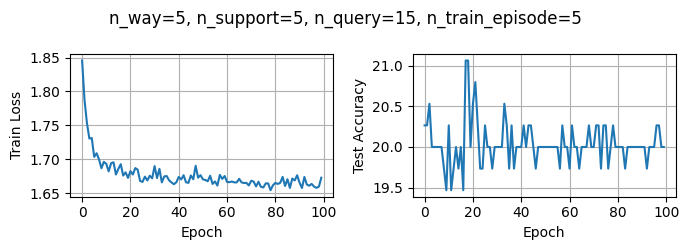

In [11]:
train_model(**parameters)